In [1]:
import tensorflow as tf 
from keras import layers
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import os 
import json 
from sklearn.model_selection import train_test_split
import cv2 as cv

In [43]:
DATA_DIR  = "D:/df/ai/vn_handwritten"
IMAGE_H = 128
BATCH_SIZE = 32
EPOCHS = 100
MAX_OUT = 256

In [3]:
with open(os.path.join(DATA_DIR,"labels.json"),"r",encoding="Utf-8") as file :
    data_labels = json.load(file)
data_images = os.listdir(os.path.join(DATA_DIR,"Data"))

In [4]:
def getTokens(data :dict):
    tokens = []
    for v in data.values():
        
        for char in v :
            if char not in tokens :
                tokens.append(char)
    return sorted(tokens)   
  
tokens = getTokens(data_labels)
stokens = "".join(tokens)
print(f"tokens :{stokens}")
print(len(tokens))

tokens : #'()+,-./0123456789:ABCDEFGHIJKLMNOPQRSTUVWXYabcdeghiklmnopqrstuvwxyzÂÊÔàáâãèéêìíòóôõùúýăĐđĩũƠơưạảấầẩậắằẵặẻẽếềểễệỉịọỏốồổỗộớờởỡợụủỨứừửữựỳỵỷỹ
140


In [5]:
def encode_label(text:str):
    tokens_dict = {char:idx for idx,char in enumerate(tokens)}
    en_text = [tokens_dict[char] for char in text]
    return en_text

text = data_labels[data_images[0]]
print(text)
en_text = encode_label(text)
print(np.array(en_text))

Số 253 đường Trần Phú, Thị trấn Nam Sách, Huyện Nam Sách, Hải Dương
[ 39 118   0  12  15  13   0  91  96 124  57  51   0  40  61 100  57   0
  36  52  87   6   0  40  52 115   0  63  61  99  57   0  34  46  56   0
  39  74  48  52   6   0  28  64  68 113  57   0  34  46  56   0  39  74
  48  52   6   0  28  98  53   0  24  96  95  57  51]


In [6]:
def split_data(images,test_size = 0.2):
    train_images,val_images = train_test_split(images,test_size=test_size,random_state=18)
    return train_images,val_images

train_images,val_images = split_data(data_images)

print(f"All :{len(data_images)}")
print(f"train images :{len(train_images)}")
print(f"valid images :{len(val_images)}")
    


All :1838
train images :1470
valid images :368


In [7]:
widths = []
for image in train_images:
    image = plt.imread(os.path.join(DATA_DIR,"Data",image))
    widths.append((int(IMAGE_H/image.shape[0]*image.shape[1])))

max_pad_width = max(widths)
print(max_pad_width)

2350


tf.Tensor(
[ 39 118   0  12  15  13   0  91  96 124  57  51   0  40  61 100  57   0
  36  52  87   6   0  40  52 115   0  63  61  99  57   0  34  46  56   0
  39  74  48  52   6   0  28  64  68 113  57   0  34  46  56   0  39  74
  48  52   6   0  28  98  53   0  24  96  95  57  51   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0

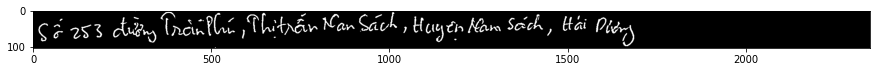

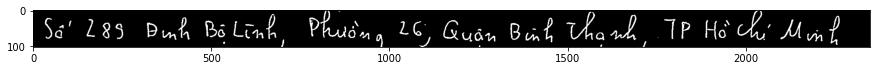

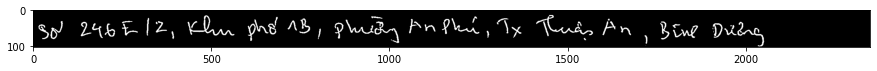

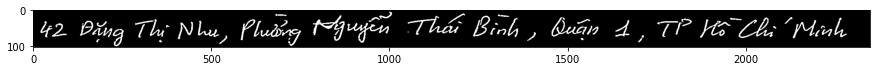

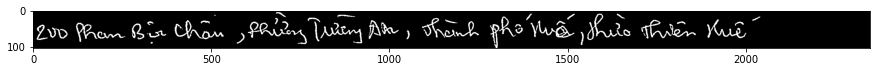

In [44]:
def loadDataset(image_path):

    image = cv.imread(os.path.join(DATA_DIR,"Data",image_path)) 
    image = cv.cvtColor(image,cv.COLOR_BGR2GRAY)

    height ,width  = image.shape
    ratio = IMAGE_H /height

    image = cv.resize(image,(int(ratio*width),height))
    image = np.pad(image,((0,0),(0,max_pad_width-image.shape[1])),mode="median")
    image = cv.GaussianBlur(image, (5,5), 0)
    image = cv.adaptiveThreshold(image,maxValue=255,adaptiveMethod=cv.ADAPTIVE_THRESH_GAUSSIAN_C,thresholdType=cv.THRESH_BINARY_INV,blockSize=11,C=4)
    image = image/255
    image = tf.convert_to_tensor(image,dtype=tf.float32)
    image = tf.expand_dims(image,axis=-1)


    label = data_labels[image_path]
    label = encode_label(label)
    label = tf.convert_to_tensor(label)
    pad_label = tf.constant([[0,MAX_OUT-label.shape[0]]])
    label = tf.pad(label,pad_label,constant_values=0)

    return image,label 

def tfData(image):
    ds = tf.data.Dataset.from_tensor_slices(image)
    ds = ds.map(loadDataset,num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.cache()
    ds = ds.prefetch(tf.data.AUTOTUNE)


for i in range(5):
    image ,label = loadDataset(data_images[i])
    plt.figure(figsize=(15,2))
    print(label)
    plt.imshow(image,cmap="gray")
    # plt.title(label)

